# Zillow Exploration
After successfully splitting the data using our functions we will explore the data to determine best features to use in our modeling. Per our guidance, the MVP will use square feet of the home, number of bedrooms, and number of bathrooms to attempt to predict the price (measured as taxvaluedollarcnt) of the home. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle
import prepare
import acquire
import env
import os

print('Success')

Success


# State, County, and tax rate
We are asked to get the staate, county, and tax rate distribution for our data set. We will do that below by using SQL to prep the data, put it into a data frame, and then find the IQR and distribution using python.

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    '''
    Returns a formatted url with login credentials to access data on a SQL database.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def load_zillow_tax_data():
    '''
    This function acquires the zillow dataset from a SQL Database.
    It returns the zillow dataset as a Pandas DataFrame.
    
    A local copy will be created as a csv file in the current directory for future use.
    '''
    db = 'zillow'
    sql_query = '''
    SELECT *,
    round(taxamount / taxvaluedollarcnt * 100, 2) as tax_rate,
    case
        when fips = 6059 then 'Orange County'
        when fips = 6037 then 'Los Angeles County'
        when fips = 6111 then 'Ventura County'
        end as "County",
    'California' as State
    from zillow.properties_2017
    join zillow.predictions_2017 
    using(parcelid)
    where transactiondate between '2017-05-01' and '2017-06-30';;
        '''
    file = 'zillow_with_tax.csv'
    
    if os.path.isfile(file):
        return pd.read_csv('zillow_with_tax.csv')
    else:
        df = pd.read_sql(sql_query, get_connection(db))
        df.to_csv('zillow_with_tax.csv', index=False)
        return df

In [3]:
# Get over all tax_rate information
zillow_tax = load_zillow_tax_data()
zillow_tax[['tax_rate']].describe()

,tax_rate
count,21936.000000
mean,1.320875
std,0.595866
min,0.010000
25%,1.160000
50%,1.230000
75%,1.350000
max,45.290000


In [4]:
oc_properties = zillow_tax[zillow_tax.fips==6059]
# Los Angeles properties
la_properties = zillow_tax[zillow_tax.fips==6037]
# Ventura County properties
vc_properties = zillow_tax[zillow_tax.fips==6111]

# Distribution of Tax Rates by County

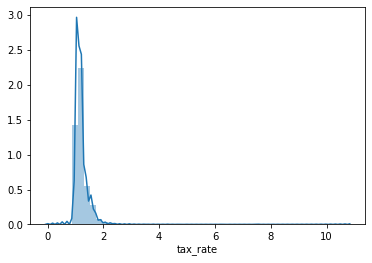

In [5]:
# Orange County
sns.distplot(oc_properties['tax_rate'])

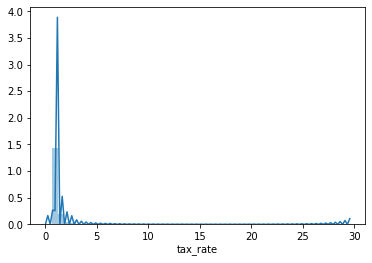

In [6]:
# Ventura County
sns.distplot(vc_properties['tax_rate'])

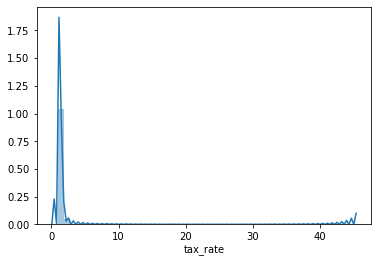

In [7]:
# LA County
sns.distplot(la_properties['tax_rate'])

# Testing Functions
The below lines of code is used to ensure that the acquire and prepare files are working correctly and to put the zillow data into Dataframes for processing. We will then split the DFs into train, validate, test data sets. 

In [8]:
zillow = acquire.load_zillow_data()
zillow.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,11393337,2463969,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,43439.0,2016.0,22755.0,756.94,Y,14.0,6.037235e+13,117,0.086137,2017-06-08
1,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
2,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
3,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,NaN,NaN,6.059064e+13,2028,0.021085,2017-06-01
4,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,NaN,NaN,6.037703e+13,3273,-0.325393,2017-06-01


In [9]:
df = prepare.prepare_zillow()
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'fullbathcnt', 'lotsizesquarefeet', 'propertylandusetypeid',
       'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'more_than_two_bath'],
      dtype='object')

In [10]:
dfmvp = prepare.prepare_zillow_mvp()
dfmvp.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,more_than_two_bath
1,2.0,3.0,1458.0,136104.0,0
2,1.0,2.0,1421.0,35606.0,0
3,3.0,4.0,2541.0,880456.0,1
4,2.0,3.0,1650.0,614000.0,0
5,1.0,2.0,693.0,274237.0,0


In [11]:
help(wrangle)

Help on module wrangle:

NAME
    wrangle

FUNCTIONS
    add_encoded_columns(df, drop_encoders=True)
        Signature: add_encoded_columns(df, drop_encoders=True)
        Docstring:
        This function accepts a DataFrame, creates encoded columns for object dtypes,
        and returns a DataFrame with or without object dtype columns.
        
        Parameters
        ----------
        df : pandas.core.frame.DataFrame
        
        
        Returns
        -------
        f, encoded_columns
    
    add_scaled_columns(X_train, X_validate, X_test, scaler=MinMaxScaler())
        Signature: add_scaled_columns(train, validate, test, scaler)
        Docstring:
        
        Parameters
        ----------
        pandas.core.frame.DataFrame
        
        
        Returns
        -------
        X_train, X_validate, X_test
    
    attributes_target_split(data_set, target_name)
        Signature: attributes_target_split(df, target)
        Docstring:
        
        Parameters
 

In [12]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.wrangle_data(dfmvp, 'taxvaluedollarcnt', modeling=True)


In [13]:
train = pd.concat([X_train, y_train], axis = 1)
train.corr()

,bathroomcnt_scaled,bedroomcnt_scaled,calculatedfinishedsquarefeet_scaled,more_than_two_bath_scaled,taxvaluedollarcnt
bathroomcnt_scaled,1.000000,0.645932,0.855318,0.766603,0.532462
bedroomcnt_scaled,0.645932,1.000000,0.633102,0.513008,0.280419
calculatedfinishedsquarefeet_scaled,0.855318,0.633102,1.000000,0.659265,0.607224
more_than_two_bath_scaled,0.766603,0.513008,0.659265,1.000000,0.330191
taxvaluedollarcnt,0.532462,0.280419,0.607224,0.330191,1.000000


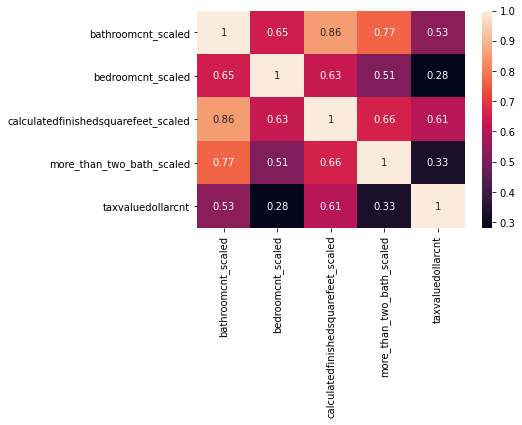

In [14]:
sns.heatmap(train.corr(), annot=True)

We'll do a correlation test on the highest correlations (bathroom count and calculated square footage)

* $H0$ - There is no relationship between taxvaluedollarcnt and bathroomcnt"
* $Ha$ - There is a relationship between taxvaluedollarcnt and bathroomcnt

In [15]:
from math import sqrt
from scipy import stats
a = .05
corr, p = stats.pearsonr(train['calculatedfinishedsquarefeet_scaled'], train['taxvaluedollarcnt'])
print(corr, p)
if p > a:
    print('We Fail to Reject H0')
else:
    print('We Reject H0')

0.6072243309769602 0.0
We Reject H0


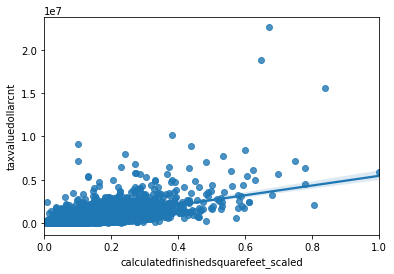

In [16]:
sns.regplot(data=train, x='calculatedfinishedsquarefeet_scaled', y = 'taxvaluedollarcnt')

In [17]:
corr, p = stats.pearsonr(train['bathroomcnt_scaled'], train['taxvaluedollarcnt'])
print(corr, p)
if p > a:
    print('We Fail to Reject H0')
else:
    print('We Reject H0')

0.532461650763184 0.0
We Reject H0


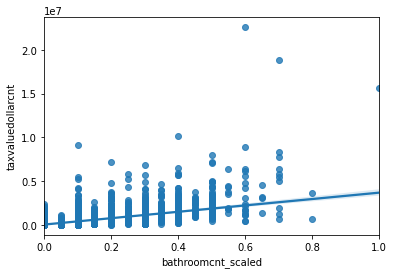

In [18]:
sns.regplot(data=train, x='bathroomcnt_scaled', y = 'taxvaluedollarcnt')

# MVP v2
## Outlier Detection
To properly create a model we will need to determine if there are any outliers in the data and then address them. We will do that below using 

In [19]:
des = zillow[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt', 'yearbuilt', 'landtaxvaluedollarcnt']].describe()
des

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,roomcnt,yearbuilt,landtaxvaluedollarcnt
count,21937.000000,21937.000000,21882.000000,21937.000000,21856.000000,2.193700e+04
mean,2.319939,3.065688,1808.426926,1.502667,1968.798957,3.103976e+05
std,0.995551,1.125518,973.442464,2.851127,23.873748,4.644192e+05
min,0.000000,0.000000,242.000000,0.000000,1824.000000,2.250000e+03
25%,2.000000,2.000000,1194.000000,0.000000,1953.000000,8.930000e+04
50%,2.000000,3.000000,1562.000000,0.000000,1970.000000,2.092070e+05
75%,3.000000,4.000000,2145.000000,0.000000,1987.000000,3.794120e+05
max,11.000000,12.000000,35640.000000,14.000000,2015.000000,1.635060e+07


In [20]:
columns = list(des.columns)

outliers = []
for col in columns:
    IQR = (des[col].iloc[6] - des[col].iloc[4])
    Q3 = des[col].iloc[6]
    Q1 = des[col].iloc[4]
    little_outliers = Q1 - (1.5 * IQR)
    big_outliers = Q3 + (1.5 * IQR)
    outliers.append([IQR, Q3, Q1, little_outliers, big_outliers])

outliers = np.array(outliers)
df_outliers = pd.DataFrame(data=outliers, index = columns, columns = ['IQR', 'Q3', 'Q1', 'little_outliers', 'big_outliers'])
df_outliers

big_outliers = df_outliers[['big_outliers']].transpose()
big_outliers

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,roomcnt,yearbuilt,landtaxvaluedollarcnt
big_outliers,4.5,7.0,3571.5,0.0,2038.0,814580.0


In [21]:
little_outliers = df_outliers[['little_outliers']].transpose()
little_outliers

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,roomcnt,yearbuilt,landtaxvaluedollarcnt
little_outliers,0.5,-1.0,-232.5,0.0,1902.0,-345868.0


In [22]:
df['bathroomcnt_outlier'] = (df['bathroomcnt'] > 4.5) | (df['bathroomcnt'] < .05)
df['bedroomcnt_outlier'] = (df['bedroomcnt'] > 5.5) | (df['bedroomcnt'] < 1.5)
df['calculatedfinishedsquarefeet_outlier'] = (df['calculatedfinishedsquarefeet'] > 3633.0)
df['roomcnt_outlier'] = (df['roomcnt'] > 12.5)
df['yearbuilt_outlier'] = (df['yearbuilt'] > 2016.5) | (df['yearbuilt'] < 1908.5)


In [23]:
print(f"bathroomcnt_outlier - {df['bathroomcnt_outlier'].sum()/df.shape[0] * 100}")
print(f"bedroomcnt_outlier - {df['bedroomcnt_outlier'].sum()/df.shape[0] * 100}")
print(f"calculatedfinishedsquarefeet_outlier - {df['calculatedfinishedsquarefeet_outlier'].sum()/df.shape[0] * 100}")
print(f"roomcnt_outlier - {df['roomcnt_outlier'].sum()/df.shape[0] * 100}")
print(f"yearbuilt_outlier - {df['yearbuilt_outlier'].sum()/df.shape[0] * 100}")

bathroomcnt_outlier - 2.904820766378245
bedroomcnt_outlier - 2.5271253948633428
calculatedfinishedsquarefeet_outlier - 5.603625875566543
roomcnt_outlier - 0.006867188572998215
yearbuilt_outlier - 0.7279219887378108


In [24]:
df.shape

(14562, 17)

In [25]:
df.drop(df.loc[df['bathroomcnt_outlier']==True].index, inplace=True)
df.drop(df.loc[df['bedroomcnt_outlier']==True].index, inplace=True)
df.drop(df.loc[df['calculatedfinishedsquarefeet_outlier']==True].index, inplace=True)
df.drop(df.loc[df['roomcnt_outlier']==True].index, inplace=True)
df.drop(df.loc[df['yearbuilt_outlier']==True].index, inplace=True)
df.shape


(13328, 17)

In [26]:
print(f"Percentage of rows removed is {(1 - 13666/14996) * 100}")

Percentage of rows removed is 8.869031741797818


In [27]:
# Drop the outlier columns we created
df.drop(columns=['bathroomcnt_outlier', 'bedroomcnt_outlier', 'calculatedfinishedsquarefeet_outlier',
                 'roomcnt_outlier', 'yearbuilt_outlier'], inplace=True)

In [28]:
# Drop all the nan rows that are present (less than 1% of the total data)
df.dropna(inplace=True)

In [29]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.wrangle_data(df, 'taxvaluedollarcnt', modeling=True)
X_train.head()

,parcelid_scaled,bathroomcnt_scaled,bedroomcnt_scaled,calculatedfinishedsquarefeet_scaled,fips_scaled,fullbathcnt_scaled,lotsizesquarefeet_scaled,propertylandusetypeid_scaled,roomcnt_scaled,yearbuilt_scaled,more_than_two_bath_scaled
8159,0.007571,0.000000,0.333333,0.155475,0.0,0.000000,0.004654,0.0,0.0,0.056604,0.0
16860,0.004160,0.571429,0.666667,0.581367,0.0,0.666667,0.005016,0.0,0.0,0.764151,1.0
8894,0.001713,0.000000,0.000000,0.156987,0.0,0.000000,0.003889,0.0,0.0,0.292453,0.0
13093,0.004618,0.000000,0.333333,0.229885,0.0,0.000000,0.004002,0.0,0.0,0.169811,0.0
11515,0.011776,0.285714,0.333333,0.220811,0.0,0.333333,0.001553,0.0,0.0,0.122642,0.0


In [30]:
X_train.columns

Index(['parcelid_scaled', 'bathroomcnt_scaled', 'bedroomcnt_scaled',
       'calculatedfinishedsquarefeet_scaled', 'fips_scaled',
       'fullbathcnt_scaled', 'lotsizesquarefeet_scaled',
       'propertylandusetypeid_scaled', 'roomcnt_scaled', 'yearbuilt_scaled',
       'more_than_two_bath_scaled'],
      dtype='object')

In [31]:
# Drop columns we can't use for K best due to values

k_X_train = X_train.drop(columns=['parcelid_scaled', 'propertylandusetypeid_scaled'])
k_X_validate = X_validate.drop(columns=['parcelid_scaled', 'propertylandusetypeid_scaled'])
k_X_test = X_test.drop(columns=['parcelid_scaled', 'propertylandusetypeid_scaled'])

In [32]:
from sklearn.feature_selection import SelectKBest, f_regression

# Create the f_selector object 
f_selector = SelectKBest(f_regression, k=5)

# fit the selector to the training data
f_selector.fit(k_X_train, y_train)

# Reduce the training data by transforming the X_train data set to the f_selector
X_reduced = f_selector.transform(k_X_train)

# Use get support to create a mask
f_support = f_selector.get_support()

f_feature = k_X_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

5 selected features
['bathroomcnt_scaled', 'bedroomcnt_scaled', 'calculatedfinishedsquarefeet_scaled', 'fullbathcnt_scaled', 'more_than_two_bath_scaled']


In [33]:
wrangle.select_kbest(k_X_train, y_train, k_features=5)

Select K Best: 5 features
['bathroomcnt_scaled', 'bedroomcnt_scaled', 'calculatedfinishedsquarefeet_scaled', 'fullbathcnt_scaled', 'more_than_two_bath_scaled']


,bathroomcnt_scaled,bedroomcnt_scaled,calculatedfinishedsquarefeet_scaled,fullbathcnt_scaled,more_than_two_bath_scaled
8159,0.000000,0.333333,0.155475,0.000000,0.0
16860,0.571429,0.666667,0.581367,0.666667,1.0
8894,0.000000,0.000000,0.156987,0.000000,0.0
13093,0.000000,0.333333,0.229885,0.000000,0.0
11515,0.285714,0.333333,0.220811,0.333333,0.0
...,...,...,...,...,...
6996,0.285714,0.333333,0.530551,0.333333,0.0
19542,0.285714,0.666667,0.498488,0.333333,0.0
8554,0.285714,0.333333,0.406836,0.333333,0.0
21121,0.285714,0.333333,0.255898,0.333333,0.0


In [34]:
# Shove the X_train and y_train data sets together to be able to graph them.
train = pd.concat([X_train, y_train], axis = 1)
train.columns

Index(['parcelid_scaled', 'bathroomcnt_scaled', 'bedroomcnt_scaled',
       'calculatedfinishedsquarefeet_scaled', 'fips_scaled',
       'fullbathcnt_scaled', 'lotsizesquarefeet_scaled',
       'propertylandusetypeid_scaled', 'roomcnt_scaled', 'yearbuilt_scaled',
       'more_than_two_bath_scaled', 'taxvaluedollarcnt'],
      dtype='object')

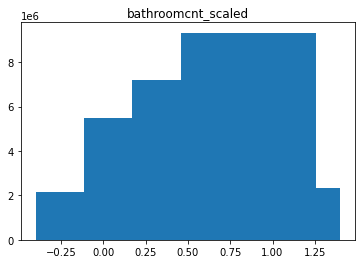

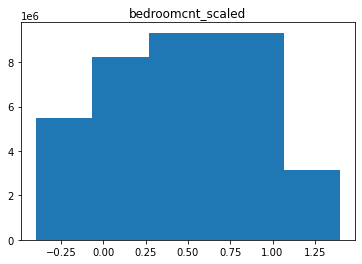

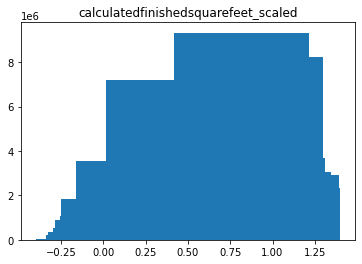

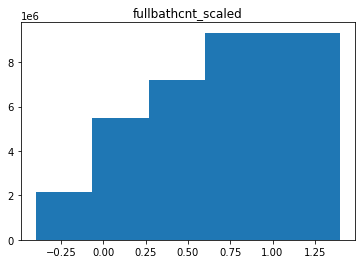

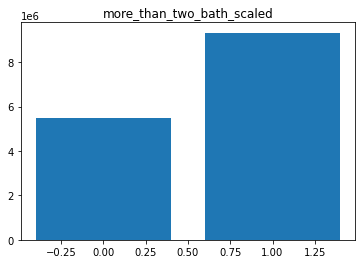

In [35]:
# Create bar plot of each of the K-Best features.

columns = ['bathroomcnt_scaled', 'bedroomcnt_scaled', 'calculatedfinishedsquarefeet_scaled', 'fullbathcnt_scaled', 'more_than_two_bath_scaled']   
for col in columns:
    plt.bar(train[col], train['taxvaluedollarcnt'])
    plt.title(col)
    plt.show()

# Basic Exploration
Below are some basic exploration of features from the train set as a whole after removing outliers

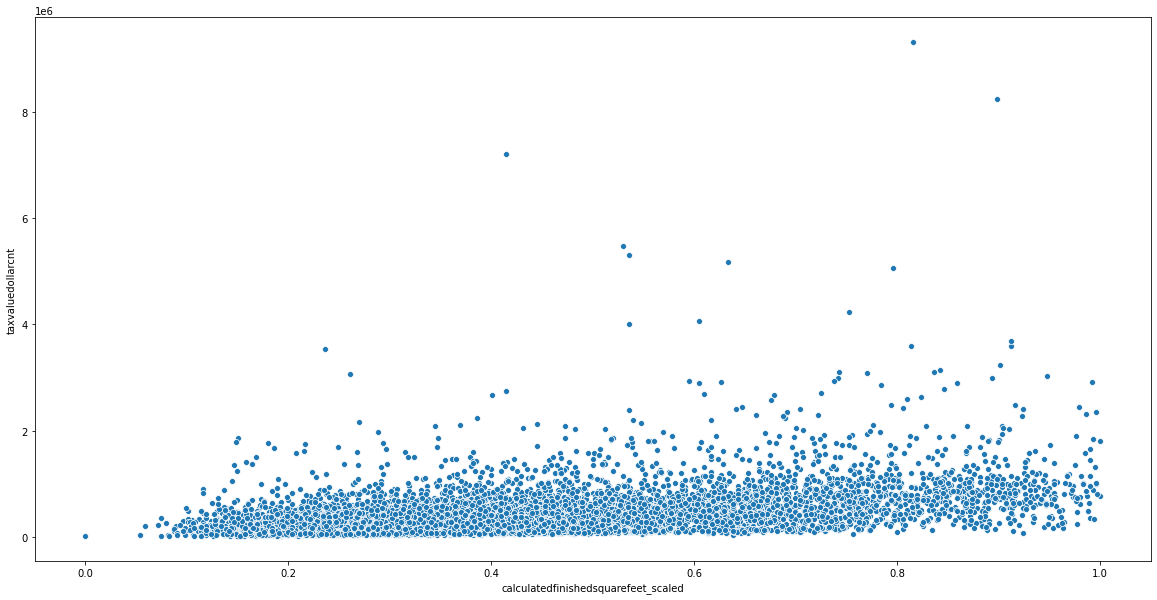

In [37]:
plt.figure(figsize = (20,10))
sns.scatterplot(data=train, x='calculatedfinishedsquarefeet_scaled', y='taxvaluedollarcnt')

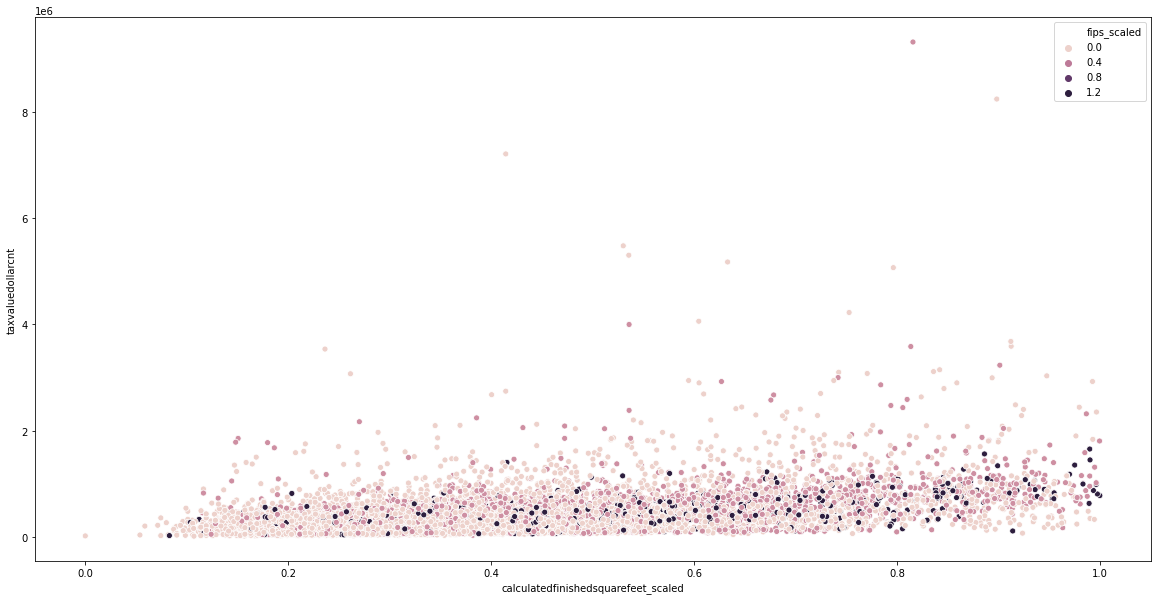

In [39]:
plt.figure(figsize = (20,10))
sns.scatterplot(data=train, x='calculatedfinishedsquarefeet_scaled', y='taxvaluedollarcnt', hue='fips_scaled')

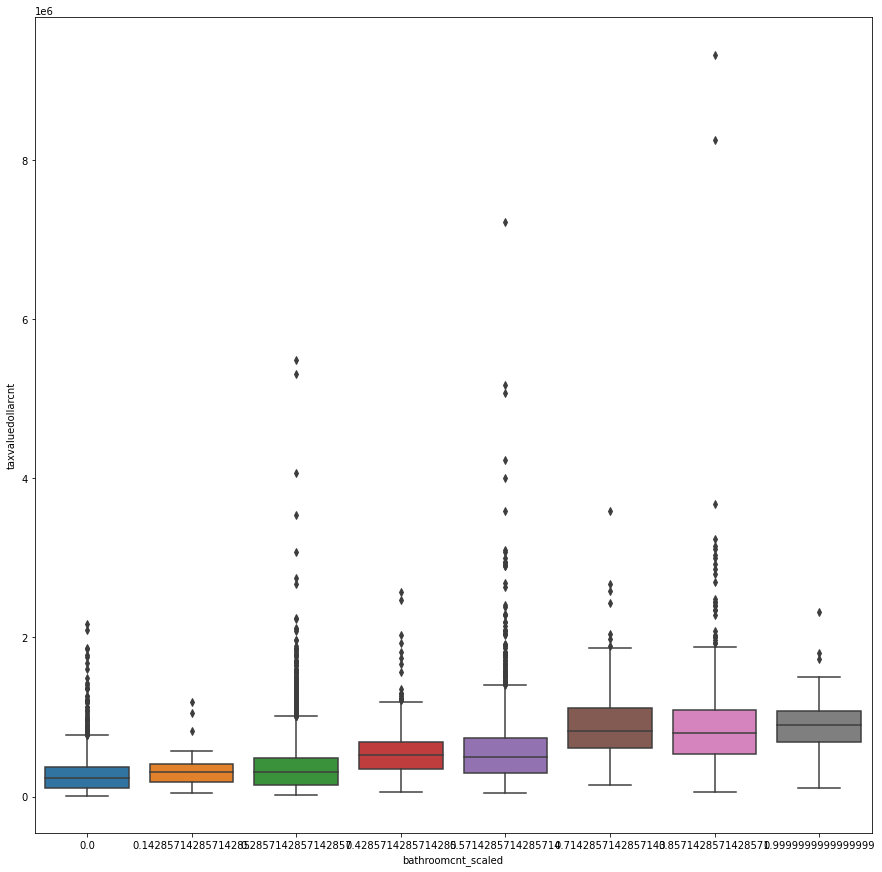

In [44]:
plt.figure(figsize = (15,15))
sns.boxplot(data=train, x='bathroomcnt_scaled', y='taxvaluedollarcnt')

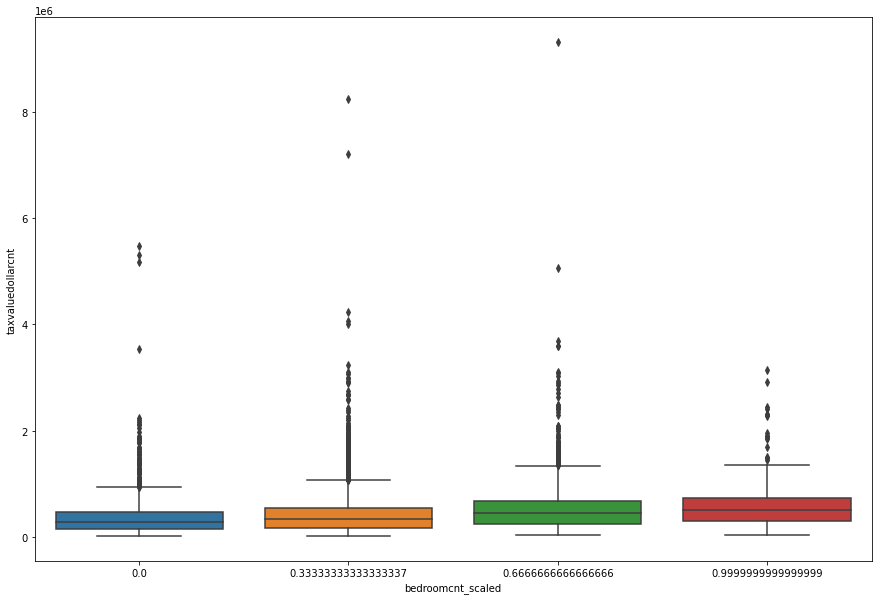

In [42]:
plt.figure(figsize = (15,10))
sns.boxplot(data=train, x='bedroomcnt_scaled', y='taxvaluedollarcnt')

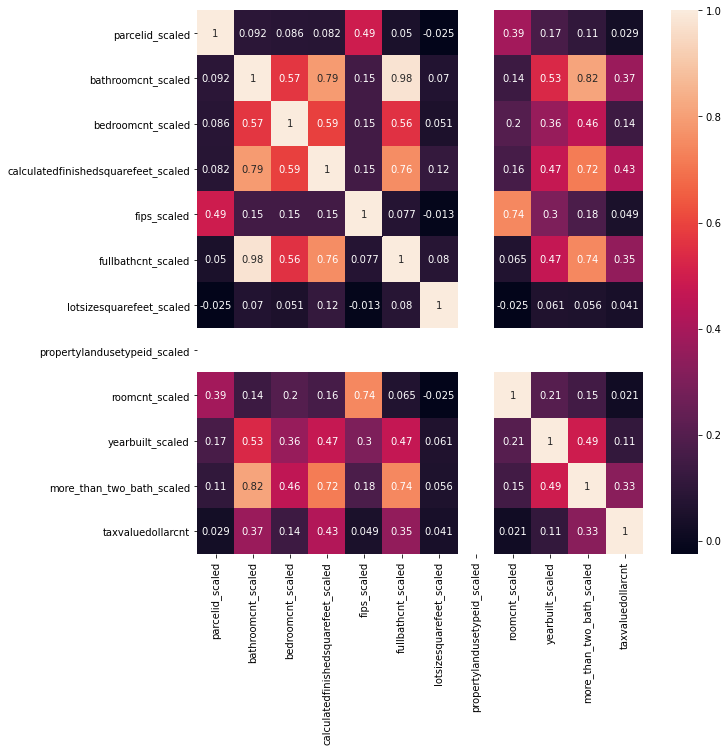

In [45]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True)